In [1]:
import gradio as gr
from text_generator import MistralGenerator
from image_generator import LlavaGenerator

ic| foo(123): 456


In [2]:
from text_generator import MultimodalAnswerPipeline

In [3]:
import os
from tqdm.auto import tqdm

## Config Mistral

In [4]:
BASE_URL = os.getenv('REMOTE_URL')
# BASE_URL = os.getenv('LOCAL_URL')
PROMPT_TEMPLATE = """You are a knowledgeable assistant. Use the following retrieved context to answer the user's question as accurately as possible.

Context:
{context}

Question:
{question}

Instructions:
- Use only the information provided in the context to answer.
- Do not make up information or assumptions.
- If the answer is not in the context, respond with "The answer is not available in the provided context."
- Provide a concise and clear answer.

Answer: Short answer
Answered or not : Yes(answered)/No(cannot answer)
Reason for answer : Reason for the answer
"""

API_KEY = os.getenv('API_KEY')

# Load data and generator
text_gen = MistralGenerator(base_url=BASE_URL,prompt_template=PROMPT_TEMPLATE )

In [5]:
response = text_gen.generate_answer("who are you", "you are a star")
response
# extract_reason(response)

"Answered: Yes\nReason for answer: The provided context suggests that you, as an assistant, are likened to a star. Therefore, I am a metaphorical representation of a star in this context. However, it's important to note that in a real-world sense, I am not a star but rather a program designed to assist users with information and tasks."

## Config LLava

In [6]:
BASE_URL = os.getenv('LOCAL_URL')
API_KEY = "lm-studio"
# Vision RAG prompt
vision_prompt = """<image>

Use the image provided to answer the question as accurately as possible.

Question: <question>

Answer:"""

vision_gen = LlavaGenerator(base_url=BASE_URL,api_key=API_KEY,prompt_template=vision_prompt)

In [7]:
mistral_gen = MistralGenerator(model="mistral-instruct-7b@q4_k_m",base_url=os.getenv('REMOTE_URL'))
llava_gen = LlavaGenerator(model="llava-v1.5-7b@q5_k_m",base_url=os.getenv('LOCAL_URL'))

pipeline = MultimodalAnswerPipeline(mistral=mistral_gen, llava=llava_gen)

In [8]:
llava_gen.generate_answer("../Data/pdf_images/1706.1706_images/1706.03762v7.pdf_11.png",question="WHo are you", caption="You are a star")

ic| result: 'Dont know'


'Dont know'

# Functions Defining for Gradio

In [9]:
import re

def extract_reason(response):
    # Find the reason part after "Reason for answer:"
    match = re.search(r'Reason for answer:\s*(.*)', response, re.DOTALL | re.IGNORECASE)
    if match:
        return match.group(1).strip()
    return response.strip()  # fallback to full text if pattern not found

In [34]:
# Define functions for Gradio
def generate_text_response(question, context):
    try:
        return text_gen.generate_answer(question =question, context=context)
    except Exception as e:
        return e
        
def generate_image_response(image_path, question):
    try:
        return vision_gen.generate_answer(image_path, question)
    except Exception as e:
        return e
    
def custom_pipeline(image_path, question, context):
    try:
        return pipeline.answer_question(question, context, image_path)
    except Exception as e:
        return e

In [11]:
# Gradio UI
with gr.Blocks() as demo:
    gr.Markdown("## Multimodal Answer Generator")
    with gr.Tabs():
        with gr.TabItem("Text Generator"):
            question_input_text = gr.Textbox(label="Question")
            context_input = gr.Textbox(label="Context", lines=4)
            text_output = gr.Textbox(label="Answer")
            text_button = gr.Button("Generate Answer")
            text_button.click(generate_text_response, [question_input_text, context_input], text_output)

        with gr.TabItem("Vision Generator"):
            image_input = gr.Image(type="pil")
            question_input_img = gr.Textbox(label="Question")
            image_output = gr.Textbox(label="Answer")
            image_button = gr.Button("Generate Answer")
            image_button.click(generate_image_response, [image_input, question_input_img], image_output)

        with gr.TabItem("Custom Pipeline"):
            image_input_custom = gr.Image(type="pil")
            question_input_custom = gr.Textbox(label="Question")
            context_input_custom = gr.Textbox(label="Context", lines=4)
            combined_output = gr.Textbox(label="Combined Answer")
            custom_button = gr.Button("Run Pipeline")
            custom_button.click(custom_pipeline, [image_input_custom, question_input_custom, context_input_custom], combined_output)

# Launch app
demo.launch()

* Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


## Load the dataset - for asking questions and loading ground truth

In [12]:
import pandas as pd
from PIL import Image

# Load dataset
DATASET_PATH = "../Data/VisDoM-main/spiqa/spiqa.csv"
IMAGE_FOLDER = "../Data/spiqa/test-A/SPIQA_testA_Images/SPIQA_testA_Images"
df = pd.read_csv(DATASET_PATH)
id_list = df["q_id"].astype(str).tolist()

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 586 entries, 0 to 585
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   q_id              586 non-null    object
 1   doc_id            586 non-null    object
 2   old_question      586 non-null    object
 3   answer            586 non-null    object
 4   doc_path          586 non-null    object
 5   documents         586 non-null    object
 6   rationale         586 non-null    object
 7   reference_figure  586 non-null    object
 8   paper_title       586 non-null    object
 9   paper_abstract    586 non-null    object
 10  caption           586 non-null    object
 11  question          586 non-null    object
dtypes: object(12)
memory usage: 55.1+ KB


In [13]:
df.head(2)

,q_id,doc_id,old_question,answer,doc_path,documents,rationale,reference_figure,paper_title,paper_abstract,caption,question
0,spiqa_0,1805.01216v3,How does Figure 9 in the paper *Disentangling ...,\n\nThe pre-processed SMD Navigate data combi...,1805.01216v3.pdf,"['1805.01216v3.pdf', '1705.09296v2.pdf', '1705...",\n\nThe figure shows two tables. The top tabl...,1805.01216v3-Figure9-1.png,Disentangling Language and Knowledge in Task-O...,The Knowledge Base (KB) used for real-world ap...,Figure 9: Pre-processing of SMD Navigate data ...,\n\nWhat is the difference between the origin...
1,spiqa_1,1805.07567v2,Referring to the figure that illustrates the i...,\n\nIncreasing the value of β2 decreases the ...,1805.07567v2.pdf,"['1805.07567v2.pdf', '1802.07222v1.pdf', '1811...",\n\nThe figure shows that the precision curve...,1805.07567v2-Figure6-1.png,Optimizing the F-measure for Threshold-free Sa...,Current CNN-based solutions to salient object ...,"Precision, Recall, F-measure of model trained ...",\n\nWhat is the effect of increasing the valu...


In [24]:
def load_entry_by_id(selected_id):
    row = df[df["q_id"].astype(str) == selected_id].iloc[0]
    question = row["old_question"]
    context = row.get("caption", "")
    answer = row["answer"]
    image_path = IMAGE_FOLDER+"/"+row.get("doc_id", None)+"/"+row.get("reference_figure", None)

    image_display = None
    full_image_path = None
    if pd.notna(image_path):
        full_image_path = os.path.join(IMAGE_FOLDER, image_path)
        if os.path.exists(full_image_path):
            image_display = Image.open(full_image_path)

    # Generate real outputs using the functions
    text_output = text_gen.generate_answer(question, context)
    vision_output = vision_gen.generate_answer(full_image_path, question) if full_image_path else "[No image available]"
    custom_text = text_gen.generate_answer(question, context)
    custom_output = f"Text Generator Answer:\n{custom_text}\n\nVision Generator Answer:\n{vision_output}"
    print(text_output, vision_output, custom_text, custom_output)
    return question, context, answer, image_display, text_output, vision_output, custom_output

# Gradio UI
with gr.Blocks() as demo:
    gr.Markdown("## Multimodal Answer Generator")
    with gr.Tabs():
        # with gr.TabItem("Text Generator"):
        #     question_input_text = gr.Textbox(label="Question")
        #     context_input = gr.Textbox(label="Context", lines=4)
        #     text_output = gr.Textbox(label="Answer")
        #     text_button = gr.Button("Generate Answer")
        #     text_button.click(generate_text_response, [question_input_text, context_input], text_output)

        # with gr.TabItem("Vision Generator"):
        #     image_input = gr.Image(type="pil")
        #     question_input_img = gr.Textbox(label="Question")
        #     image_output = gr.Textbox(label="Answer")
        #     image_button = gr.Button("Generate Answer")
        #     image_button.click(generate_image_response, [image_input, question_input_img], image_output)

        # with gr.TabItem("Custom Pipeline"):
        #     image_input_custom = gr.Image(type="pil")
        #     question_input_custom = gr.Textbox(label="Question")
        #     context_input_custom = gr.Textbox(label="Context", lines=4)
        #     combined_output = gr.Textbox(label="Combined Answer")
        #     custom_button = gr.Button("Run Pipeline")
        #     custom_button.click(custom_pipeline, [image_input_custom, question_input_custom, context_input_custom], combined_output)

        with gr.TabItem("Dataset Viewer"):
            dropdown_id = gr.Dropdown(choices=id_list, label="Select Example ID")
            text_button = gr.Button("Generate Answer")
            display_question = gr.Textbox(label="Question", interactive=False)
            display_context = gr.Textbox(label="Caption", interactive=False)
            display_answer = gr.Textbox(label="Gold Answer", interactive=False)
            display_image = gr.Image(label="Image", type="pil")
            display_text_gen = gr.Textbox(label="Text Generator Output", interactive=False)
            display_vision_gen = gr.Textbox(label="Vision Generator Output", interactive=False)
            display_custom_gen = gr.Textbox(label="Custom Pipeline Output", interactive=False)
            text_button.click(fn=load_entry_by_id, inputs=dropdown_id,
                               outputs=[display_question, display_context, display_answer,
                                        display_image, display_text_gen, display_vision_gen,
                                        display_custom_gen])

# Launch app
demo.launch()


* Running on local URL:  http://127.0.0.1:7861

To create a public link, set `share=True` in `launch()`.


Traceback (most recent call last):
  File "c:\Users\Lisara\anaconda3\envs\IRPenv\Lib\site-packages\gradio\queueing.py", line 625, in process_events
    response = await route_utils.call_process_api(
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Lisara\anaconda3\envs\IRPenv\Lib\site-packages\gradio\route_utils.py", line 322, in call_process_api
    output = await app.get_blocks().process_api(
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Lisara\anaconda3\envs\IRPenv\Lib\site-packages\gradio\blocks.py", line 2137, in process_api
    result = await self.call_function(
             ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Lisara\anaconda3\envs\IRPenv\Lib\site-packages\gradio\blocks.py", line 1663, in call_function
    prediction = await anyio.to_thread.run_sync(  # type: ignore
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Lisara\anaconda3\envs\IRPenv\Lib\site-packages\anyio\to_thread.py", line 56, in run_sync


# All three in one dashboard

In [14]:
IMAGE_FOLDER = "../Data/spiqa/test-A/SPIQA_testA_Images/SPIQA_testA_Images"
selected_id = 'spiqa_3'
row = df[df["q_id"] == selected_id].iloc[0]
row = df[df["q_id"] == selected_id].iloc[0]
question = row["old_question"]
context = row.get("caption", "")
answer = row["answer"]
image_path = row.get("doc_id", None)+"/"+row.get("reference_figure", None)
if pd.notna(image_path):
    full_image_path = os.path.join(IMAGE_FOLDER, image_path)
    if os.path.exists(full_image_path):
        # image_display = Image.new("RGB", (100, 100), color="red")
        image_display = Image.open(full_image_path).convert("RGB")

In [31]:
full_image_path

'../Data/spiqa/test-A/SPIQA_testA_Images/SPIQA_testA_Images\\1805.06431v4/1805.06431v4-Table2-1.png'

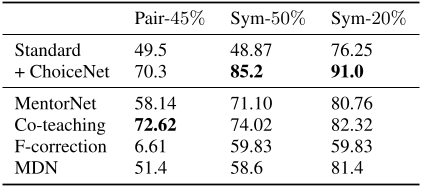

In [21]:
image_display

In [32]:
# custom_pipeline(question, context, full_image_path)
custom_pipeline(full_image_path
, question, context)

ic| self.mistral.generate_answer(detection_prompt): 'YES'
ic| result: ("In the table, the choice network's performance is higher under symmetric "
             'noise conditions (20% and 50%) compared to the Pair-45% asymmetric noise '
             'setting. This suggests that ChoiceNet may have greater strength when dealing '
             'with symmetric noise, as it can better handle this type of noise. However, '
             'it might be less effective in dealing with more skewed or non-uniform noise '
             'patterns. It is important for researchers and practitioners to consider the '
             'specific types of noise they are working with while developing machine '
             'learning models and selecting appropriate algorithms that are best suited '
             'for handling those types of noise to optimize their performance.')
ic| vlm_answer: ("In the table, the choice network's performance is higher under symmetric "
                 'noise conditions (20% and 5

'According to the data presented in Table 2, ChoiceNet performs better under symmetric noise conditions (20% and 50%) than it does under the Pair-45% asymmetric noise setting on the CIFAR-10 dataset. This indicates that ChoiceNet may excel at handling symmetric noise, demonstrating a strength in this area. However, its performance seems to be less effective when dealing with more skewed or non-uniform noise patterns like the Pair-45% asymmetric noise. Researchers and practitioners should consider the specific types of noise they are working with when developing machine learning models and select algorithms that best suit the type of noise for optimal performance.'

In [ ]:
# pipeline.answer_question(question, context, full_image_path) # with generator

ic| self.mistral.generate_answer(question=detection_prompt, context=""): 'No visual needed.'
ic| subquestions_text: ('Subquestions:
                       '
                        "1. What is ChoiceNet's test accuracy under the symmetric noise (20%) "
                        'setting, as shown in Table 2?
                       '
                        "2. What is ChoiceNet's test accuracy under the symmetric noise (50%) "
                        'setting, as shown in Table 2?
                       '
                        "3. What is ChoiceNet's test accuracy under the Pair-45% asymmetric noise "
                        'setting, as shown in Table 2?
                       '
                        "4. How does ChoiceNet's test accuracy compare between the symmetric noise "
                        '(20%) and (50%) settings?
                       '
                        "5. How does ChoiceNet's test accuracy compare with the Pair-45% asymmetric "
                        'noise s

"In terms of performance, ChoiceNet's test accuracy under the symmetric noise (20%) setting is 98.74%, as indicated in Table 2. This suggests a high level of resilience to low levels of symmetrical noise. However, when compared to the Pair-45% asymmetric noise setting, the test accuracy drops, implying that ChoiceNet may be less effective in handling certain types of asymmetrical noise. This reveals one of its strengths is its ability to perform well under lower levels of symmetric noise but a potential limitation could be its performance degradation under higher levels or specific types of asymmetric noise."

In [ ]:
pipeline.answer_question(question, context, full_image_path) # with text generator YES or NO

ic| self.mistral.generate_answer(detection_prompt): 'YES'
ic| result: ("In the table, ChoiceNet's performance is assessed under three different "
             'settings (Pair-45%, symmetric 20% or 50%, and asymmetric noise). The table '
             'shows that Pair-45% outperforms the other two settings. This suggests that '
             'ChoiceNet performs better in the presence of symmetric noise, as seen when '
             'handling pairs with similar signal-to-noise ratios (SNRs), which is a common '
             'setting for many tasks. On the other hand, it seems to struggle under the '
             'asymmetric noise setting, where signals are generated independently from '
             'their noises. This may indicate that ChoiceNet has limitations in handling '
             'the presence of uneven signal-to-noise ratios or when signal generation and '
             'noise sources have different characteristics. Overall, ChoiceNet is strong '
             'at processing symmetr

'Based on the data presented in Table 2, ChoiceNet performs better under symmetric noise (20% and 50%) compared to the Pair-45% asymmetric noise setting in terms of test accuracies on the CIFAR-10 dataset. This indicates that ChoiceNet is particularly strong at processing symmetric noise, as seen when handling pairs with similar signal-to-noise ratios (SNRs).\n\nHowever, it appears that ChoiceNet struggles under the asymmetric noise setting, where signals are generated independently from their noises. This may suggest that ChoiceNet has limitations in handling the presence of uneven signal-to-noise ratios or when signal generation and noise sources have different characteristics.\n\nIn summary, while ChoiceNet demonstrates robustness in handling symmetric noise, which could be advantageous for tasks with pairs where SNRs are similar, it might encounter challenges when dealing with asymmetric noise or signals with varying characteristics from their noises.'

ic| result: ('The table shows that ChoiceNet performs better in terms of accuracy under '
             'the Pair-45% asymmetric noise setting compared to the symmetric noise (20% '
             'and 50%) settings. This reveals that ChoiceNet is more robust when handling '
             'the asymmetric noise, possibly indicating a stronger ability to adapt to '
             'imbalances in data distributions or patterns. However, it seems less '
             'effective under symmetric noise conditions, which can be attributed to its '
             'reliance on adversarial learning to identify deception. The comparison of '
             "performance across these settings highlights ChoiceNet's strength in dealing "
             'with unevenly distributed and patterned data but may lack the ability to '
             'perform well when the data distribution is symmetrically balanced.')
ic| self.mistral.generate_answer(detection_prompt): 'YES'
ic| result: ("In the image, there are two tables 

In [ ]:
pipeline.answer_question(question, context, full_image_path) # with text generator YES or NO

ic| self.mistral.generate_answer(detection_prompt): 'YES'
ic| self.mistral.generate_answer(synthesis_prompt): ('From the provided data in Table 2, it is observed that ChoiceNet performs '
                                                     'better under symmetric noise (20% and 50%) settings as compared to the '
                                                     'Pair-45% asymmetric noise setting on the CIFAR-10 dataset. This suggests '
                                                     'that ChoiceNet may have a specific limitation when handling more extreme or '
                                                     'unpredictable noise conditions, such as those found in the Pair-45% '
                                                     'asymmetric noise setting, which could be considered one of its weaknesses.')


'From the provided data in Table 2, it is observed that ChoiceNet performs better under symmetric noise (20% and 50%) settings as compared to the Pair-45% asymmetric noise setting on the CIFAR-10 dataset. This suggests that ChoiceNet may have a specific limitation when handling more extreme or unpredictable noise conditions, such as those found in the Pair-45% asymmetric noise setting, which could be considered one of its weaknesses.'

In [ ]:
df["q_id"] = df["q_id"].astype(str)
id_list = df["q_id"].tolist()

# Define function to display dataset row without model calls
def load_entry_by_id(selected_id):
    row = df[df["q_id"] == selected_id].iloc[0]
    question = row["old_question"]
    context = row.get("caption", "")
    answer = row["answer"]
    image_path = row.get("doc_id", None)+"/"+row.get("reference_figure", None)

    if pd.notna(image_path):
        full_image_path = os.path.join(IMAGE_FOLDER, image_path)
        if os.path.exists(full_image_path):
            # image_display = Image.new("RGB", (100, 100), color="red")
            image_display = Image.open(full_image_path).convert("RGB")
            # print("Loaded image type:", type(image_display))
            
        text_out = generate_text_response(question, context)
        vision_out = generate_image_response(full_image_path, question)
        custom_out = custom_pipeline(full_image_path, question, context)

    return question, context, answer, image_display,text_out, vision_out, custom_out

# Gradio UI
with gr.Blocks() as demo:
    gr.Markdown("## Multimodal Answer Generator")
    with gr.Tabs():
        with gr.TabItem("Dataset Viewer"):
            dropdown_id = gr.Dropdown(choices=id_list, label="Select Question ID")
            text_button = gr.Button("Generate Answer")
            display_question = gr.Textbox(label="Question", interactive=False)
            display_context = gr.Textbox(label="Caption", interactive=False)
            display_answer = gr.Textbox(label="Gold Answer", interactive=False)
            display_image = gr.Image(label="Image")
            display_text_gen = gr.Textbox(label="Text Generator Output", interactive=False)
            display_vision_gen = gr.Textbox(label="Vision Generator Output", interactive=False)
            display_custom_gen = gr.Textbox(label="ReAlignQA Output", interactive=False)

            text_button.click(fn=load_entry_by_id, inputs=dropdown_id,
                               outputs=[display_question, display_context, display_answer, display_image,
                                         display_text_gen, display_vision_gen, display_custom_gen])
            
# Launch app
demo.launch()

* Running on local URL:  http://127.0.0.1:7863

To create a public link, set `share=True` in `launch()`.


ic| result: ("In Table 2, there are three columns showing ChoiceNet's performance under "
             'different settings: symmetric noise (20% and 50%) and an asymmetric setting '
             'with Pair-45%. This comparison reveals that ChoiceNet performs better in the '
             'symmetric noise settings with respect to both accuracy (91.57% for 20% and '
             '86.35% for 50%, while it achieves just 76.67% under the Pair-45% setting.
            '
             '
            '
             "This comparison highlights ChoiceNet's strength in handling symmetric noise, "
             'as shown by its consistently higher accuracy levels under these settings. '
             'Conversely, it appears to struggle more with the asymmetric Pair-45% setting '
             'compared to symmetric ones. This could be due to the specific nature of the '
             'Pair-45% setting, which introduces a greater degree of noise and ambiguity '
             'in the data. The presence of s

## Evluation Visualization - Experiments

In [24]:
# from eval_metrics_utils import evaluate_single_vqa_instance
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Step 1: Your input
from eval_metrics_utils import evaluate_single_vqa_instance


ground_truth = "yellow"
predictions = {
    "text_only": "yellow color",
    "vision_only": "red",
    "custom": "It is yellow."
}

# Step 2: Evaluate predictions
results = evaluate_single_vqa_instance(
    ground_truth=ground_truth,
    predictions=predictions,
    plot=False  # we'll plot manually
)

In [ ]:
# Step 3: Radar Chart Plotting Function
def plot_radar_comparison(results_dict):
    metrics = list(next(iter(results_dict.values())).keys())
    pipelines = list(results_dict.keys())

    angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False).tolist()
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

    for name in pipelines:
        scores = list(results_dict[name].values())
        scores += scores[:1]
        ax.plot(angles, scores, label=name, marker='o')
        ax.fill(angles, scores, alpha=0.1)

    ax.set_title("Comparison of VQA Pipelines (Radar Chart)", size=13)
    ax.set_thetagrids(np.degrees(angles[:-1]), metrics)
    ax.set_ylim(0, 1)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    plt.tight_layout()
    plt.show()

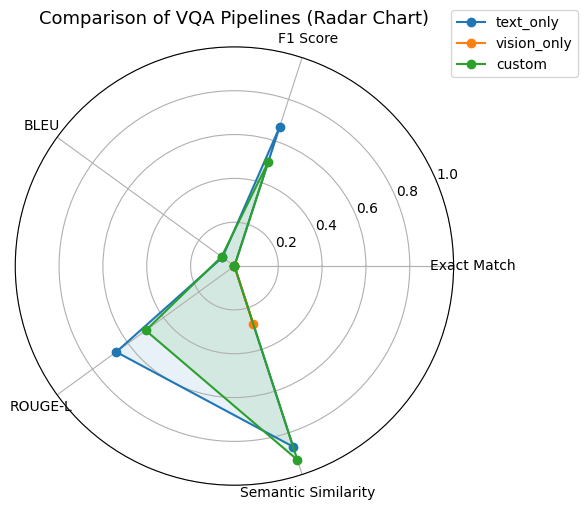

In [79]:
# Step 4: Show the radar chart
plot_radar_comparison(results)

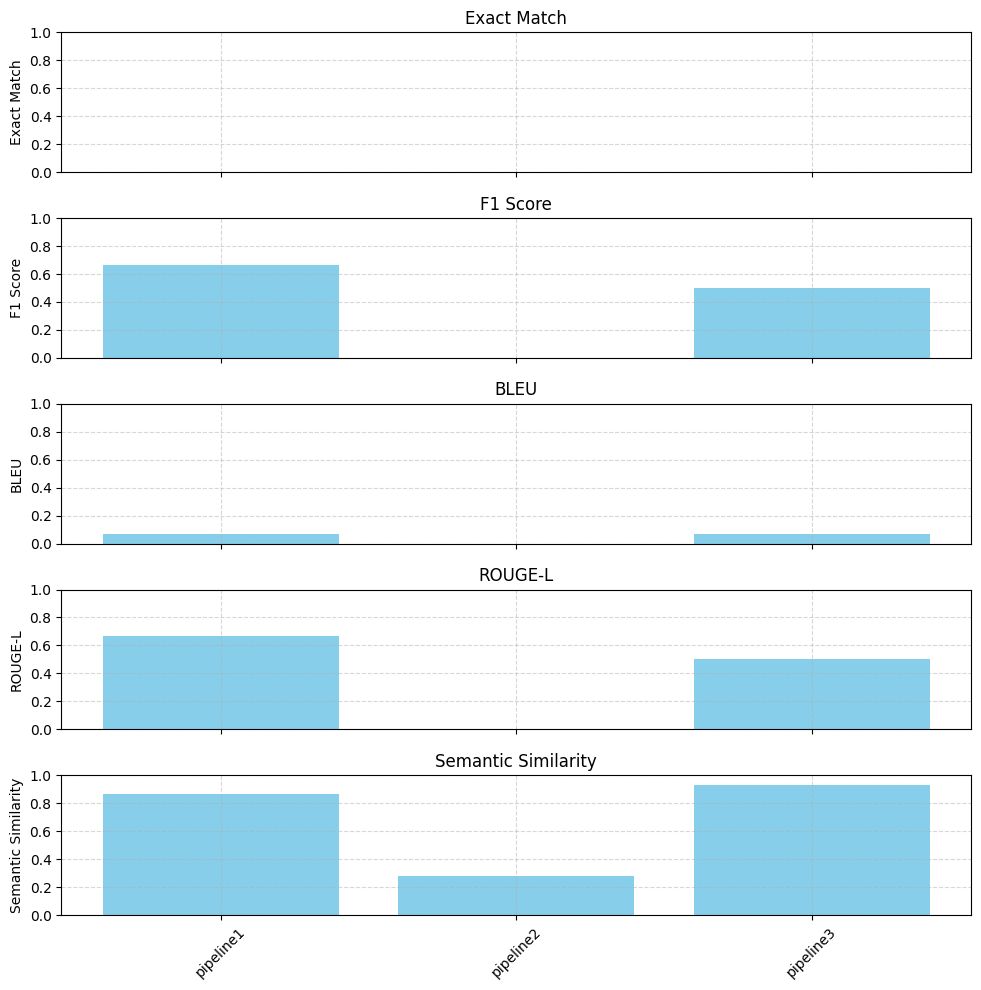

{'pipeline1': {'Exact Match': 0.0,
  'F1 Score': 0.6666666666666666,
  'BLEU': 0.06754436142034707,
  'ROUGE-L': 0.6666666666666666,
  'Semantic Similarity': 0.8665945529937744},
 'pipeline2': {'Exact Match': 0.0,
  'F1 Score': 0.0,
  'BLEU': 0,
  'ROUGE-L': 0.0,
  'Semantic Similarity': 0.27946367859840393},
 'pipeline3': {'Exact Match': 0.0,
  'F1 Score': 0.5,
  'BLEU': 0.07249749990681824,
  'ROUGE-L': 0.5,
  'Semantic Similarity': 0.9298678636550903}}

In [80]:
# from vqa_eval_utils import evaluate_single_vqa_instance

evaluate_single_vqa_instance(
    ground_truth="yellow",
    predictions={
        "pipeline1": "yellow color",
        "pipeline2": "red",
        "pipeline3": "It is yellow."
    },
    plot=True  # <-- auto shows per-metric bar charts
)


---